In [29]:
from datetime import datetime

import time
import os
import sys
from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits

import matplotlib
#matplotlib.use('nbagg')
import matplotlib.colors as mcolors

from matplotlib import style
style.use("seaborn")
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
#%matplotlib widget

SMALLER_SIZE = 14
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
rootdir = Path("/mnt/f/wfsdat")
# use find to make this csv list
with open(rootdir / "all_seeing.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [3]:
g = data.groupby('wfs')
g.wfs.describe()

count unique       top    freq
wfs                                      
binospec  102020      1  binospec  102020
f5         98774      1        f5   98774
mmirs      81270      1     mmirs   81270
newf9       3047      1     newf9    3047
oldf9      55728      1     oldf9   55728

In [4]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
#data['seeing'][data['seeing'].apply(isinstance, args=(str,))] = 0.0
fixed = data[[isinstance(x, float) for x in data['seeing']]]
fixed['seeing'] = fixed['seeing'].astype(float)
fixed = fixed[np.isfinite(fixed['seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.2]
fixed = fixed[fixed['seeing'] < 4.]
fixed = fixed[np.isfinite(fixed['airmass'])]
#fixed = fixed[fixed['time'] < "2020-12-31"]

<ipython-input-4-df6c348c280e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed['seeing'] = fixed['seeing'].astype(float)


In [5]:
fixed.sort_values(by='time')

time       wfs  \
135         2003-04-11T04:46:44     oldf9   
136         2003-04-11T04:47:06     oldf9   
137         2003-04-11T04:47:27     oldf9   
138         2003-04-11T04:52:40     oldf9   
139         2003-04-11T04:55:15     oldf9   
..                          ...       ...   
712  2021-04-08T11:52:54.858000  binospec   
713  2021-04-08T11:53:38.102000  binospec   
714  2021-04-08T11:54:21.338000  binospec   
715  2021-04-08T11:55:04.579000  binospec   
716  2021-04-08T11:55:47.849000  binospec   

                                     file  exptime  airmass          az  \
135              20030410_start_0001.fits     20.0   1.0600  177.889000   
136              20030410_start_0002.fits     20.0   1.0600  178.162000   
137              20030410_start_0003.fits     20.0   1.0600  178.427000   
138          20030410_start_cor_0000.fits     20.0   1.0600  182.299000   
139          20030410_start_cor_0001.fits     20.0   1.0600  184.205000   
..                                    ...      ...      ...         ...   
712  wfs_ff_cal_img_2021.0408.115254.fits     40.0   1.3239  316.166560   
713  wfs_ff_cal_img_2021.0408.115338.fits     40.0   1.3261  316.134384   
714  wfs_ff_cal_img_2021.0408.115421.fits     40.0   1.3282  316.102874   
715  wfs_ff_cal_img_2021.0408.115504.fits     40.0   1.3304  316.072393   
716  wfs_ff_cal_img_2021.0408.115547.fits     40.0   1.3326  316.041988   

            el  osst  outt  chamt  ...  focerr  cc_x_err  cc_y_err  \
135  70.693000   NaN   NaN    NaN  ...    9.25     0.000    -0.000   
136  70.696000   NaN   NaN    NaN  ...    2.05     0.000    -0.000   
137  70.699000   NaN   NaN    NaN  ...    2.36     0.000    -0.622   
138  70.698000   NaN   NaN    NaN  ...  -39.19     0.000    -0.000   
139  70.670000   NaN   NaN    NaN  ...   17.41    -0.000    -0.000   
..         ...   ...   ...    ...  ...     ...       ...       ...   
712  49.053621  9.28   9.4  9.206  ...    0.00    -1.703     0.000   
713  48.948103  9.25   9.4  9.096  ...   -1.74    -0.955     0.000   
714  48.841662  9.28   9.3  9.094  ...   -0.76    -1.401     0.000   
715  48.733548  9.32   9.3  9.173  ...    0.00    -1.526     0.000   
716  48.625069  9.30   9.3  9.269  ...   -0.13    -0.985    -0.000   

           xcen        ycen    seeing  raw_seeing      fwhm  wavefront_rms  \
135  260.015521  267.004039  0.977057    0.977057  7.205232     765.359307   
136  259.989181  266.980205  1.005677    1.005677  7.352807     775.887303   
137  260.020751  266.977415  0.999719    0.999719  7.322095     755.812601   
138  257.009320  269.976762  0.770863    0.770863  6.139361    1125.153415   
139  254.984789  273.000265  0.754799    0.754799  6.056333     665.754486   
..          ...         ...       ...         ...       ...            ...   
712  276.012870  248.986231  1.736434    2.054809  9.243360     240.598424   
713  276.993555  249.013150  1.593198    1.887189  8.629781     191.618679   
714  277.008188  248.988648  1.868889    2.215856  9.826204     247.771417   
715  277.983364  248.016150  1.640075    1.946494  8.847711     165.648747   
716  277.005863  250.003324  1.625740    1.931395  8.792312     174.831815   

     residual_rms  
135   3561.538896  
136   3529.074509  
137   3515.532334  
138   3372.555244  
139   3364.324103  
..            ...  
712   1230.950963  
713   1416.264337  
714   1075.100371  
715   1274.331863  
716   1215.283697  

[337767 rows x 25 columns]

In [6]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

In [7]:
fixed['seeing'].median()

0.9876331613731486

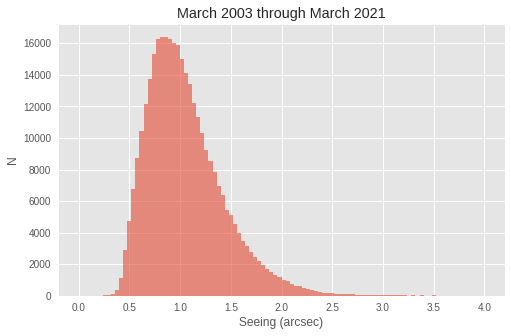

In [8]:
# make raw histogram of the zenith-corrected seeing column
#fixed.hist(column='seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    plt.hist(fixed['seeing'], bins=100, range=(0.0, 4.), alpha=0.6)
    plt.title("March 2003 through March 2021")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
plt.show()

In [9]:
# fit a log-normal distribution to the seeing data
seeing = np.array(fixed['seeing'], dtype=float)
sigma, loc, exp_mu = lognorm.fit(seeing)
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.median(seeing)
fit_median = exp_mu + loc

0.38920996857787016 0.10144394915770152 0.8835798174333644


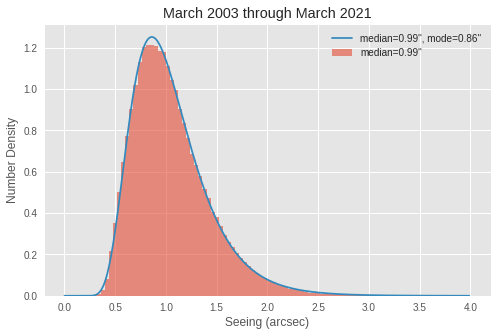

In [10]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(fixed['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title("March 2003 through March 2021")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig("all_hist.png")
plt.show()

In [11]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['seeing'])
med_2nd = np.median(second_half['seeing'])

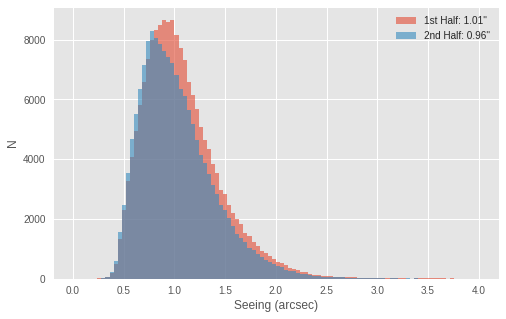

In [12]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("all_1st2nd.png")
plt.show()

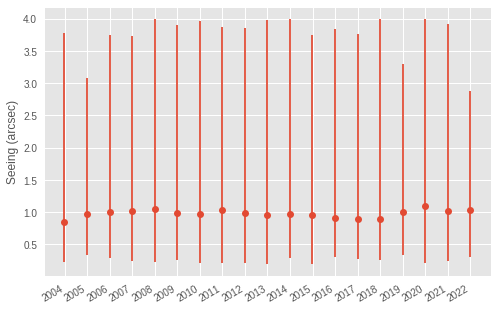

In [13]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots()
monthly = pd.DataFrame()
monthly['seeing'] = fixed.seeing.resample('Y').median()
monthly['max'] = fixed.seeing.resample('Y').max()
monthly['min'] = fixed.seeing.resample('Y').min()
lowb = monthly['seeing'] - monthly['min']
upb = monthly['max'] - monthly['seeing']
plt.errorbar(monthly.index, monthly['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.autofmt_xdate()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("all_nightly.png")
plt.show()

In [14]:
month_list = list(monthly.index.strftime('%Y'))
data = [np.array(fixed.loc[month]['seeing']) for month in month_list]
clean_data = {}
for d, arr in zip(month_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
month_labels = [datetime.strptime(d, "%Y").date() for d in clean_data.keys()]
sizes = [len(clean_data[y]) for y in clean_data]

In [15]:
first_meds = []
sec_meds = []
for y in clean_data:
    year = fixed.loc[y]
    first_half = year.between_time(start_time='00:00', end_time='07:00')
    second_half = year.between_time(start_time='07:00', end_time='14:00')
    med_1st = np.median(first_half['seeing'])
    med_2nd = np.median(second_half['seeing'])
    first_meds.append(med_1st)
    sec_meds.append(med_2nd)
    print(f"{y}: {med_1st:.2f} {med_2nd:.2f}")

2003: 0.83 0.85
2004: 0.97 1.00
2005: 1.07 0.94
2006: 1.01 1.02
2007: 1.08 1.00
2008: 1.00 0.97
2009: 0.96 1.00
2010: 1.05 1.03
2011: 0.99 0.97
2012: 0.96 0.94
2013: 1.04 0.90
2014: 0.99 0.91
2015: 0.95 0.85
2016: 0.95 0.85
2017: 0.90 0.88
2018: 1.01 0.99
2019: 1.10 1.10
2020: 1.05 0.98
2021: 1.09 0.99


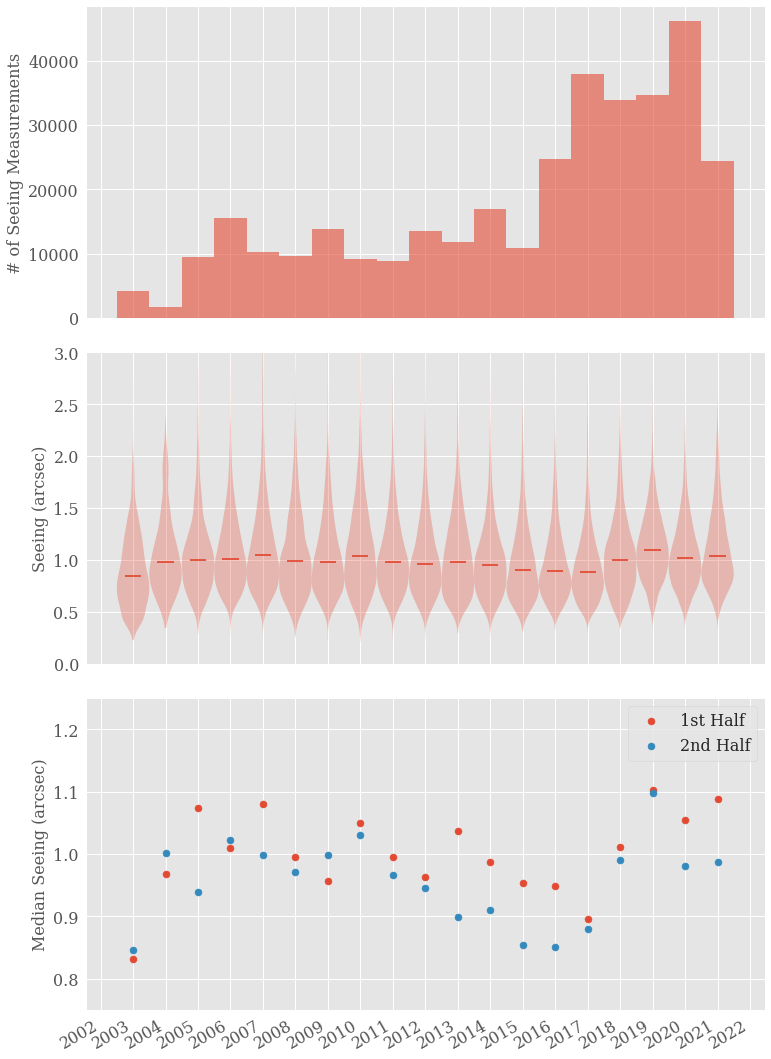

In [22]:
with plt.style.context('ggplot'):
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
    fig, ax = plt.subplots(3, figsize=(11,15), sharex=True)
    ax[0].bar(mdates.date2num(month_labels), sizes, width=366, alpha=0.6)
    ax[0].set_ylabel("# of Seeing Measurements")
    ax[1].violinplot(clean_data.values(), mdates.date2num(month_labels), points=100, widths=365,
                showextrema=False, showmedians=True, bw_method='silverman')


    ax[1].set_ylim(0.0, 3.0)
    ax[1].set_ylabel("Seeing (arcsec)")
    ax[2].scatter(mdates.date2num(month_labels), first_meds, label="1st Half")
    ax[2].scatter(mdates.date2num(month_labels), sec_meds, label="2nd Half")
    ax[2].legend(frameon=True, fancybox=True)
    ax[2].set_ylim(0.75, 1.25)
    ax[2].set_ylabel("Median Seeing (arcsec)")
    ax[2].xaxis.set_major_locator(mdates.YearLocator())
    ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.savefig("all_violin.png")
    plt.show()

In [23]:
[len(clean_data[y]) for y in clean_data]

[4157,
 1751,
 9491,
 15561,
 10326,
 9686,
 13914,
 9217,
 8842,
 13509,
 11768,
 16896,
 10823,
 24738,
 37888,
 33842,
 34695,
 46168,
 24495]

In [24]:
diff = fixed['osst'] - fixed['outt']
trim_seeing = fixed['seeing'][np.abs(diff) < 100]
diff = diff[np.abs(diff) < 100]

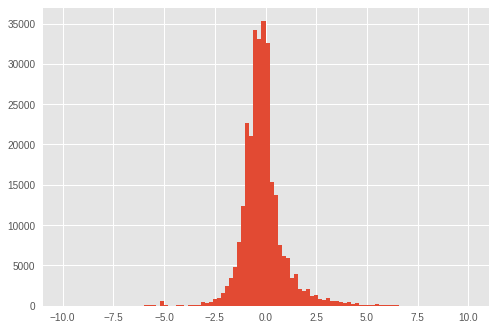

In [25]:
plt.hist(diff, bins=100, range=(-10, 10))
plt.show()

In [26]:
temps = list(range(-3,6))
t_meds = []
for t in temps:
    seeing_slice = trim_seeing[(diff >= t-0.5) & (diff <= t+0.5)]
    t_meds.append(np.median(seeing_slice))
t_meds, temps

([1.1389170340225985,
  1.0082133493904204,
  0.9472973759470648,
  0.9698903816056036,
  1.0538520702219996,
  1.1264048147264316,
  1.2477153292708285,
  1.2826657435759314,
  1.4298977456996254],
 [-3, -2, -1, 0, 1, 2, 3, 4, 5])

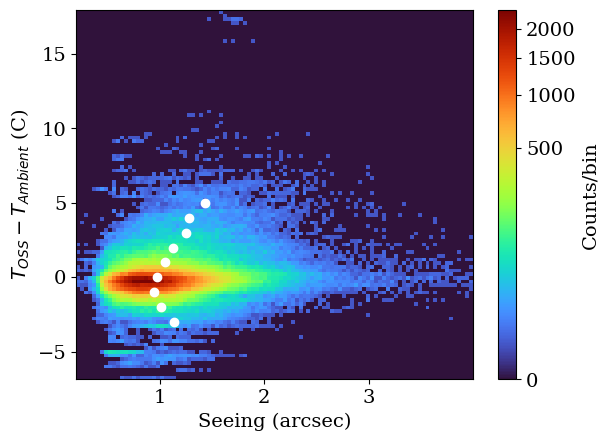

In [30]:
with plt.style.context('default'):
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    plt.hist2d(trim_seeing, diff, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("$T_{OSS} - T_{Ambient}$ (C)")
    cb = plt.colorbar()
    cb.set_label("Counts/bin")
    plt.scatter(t_meds, temps, color='w')
    plt.savefig("seeing_tempdiff.png")
    plt.savefig("seeing_tempdiff.pdf")
    plt.show()

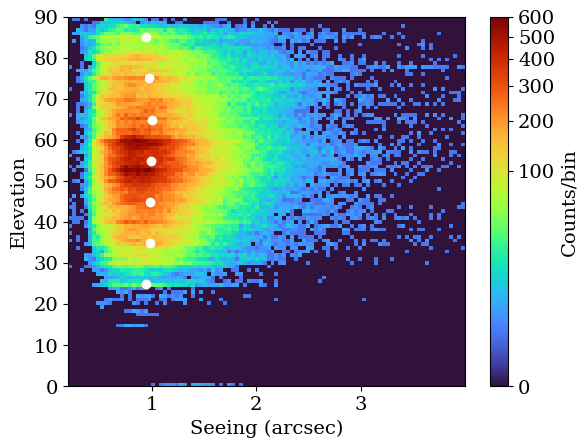

In [31]:
trimmed = fixed[np.isfinite(fixed['seeing']) & np.isfinite(fixed['el'])]
trim_el = trimmed['el'].astype(float)
el_seeing = trimmed['seeing'].astype(float)
els = [25, 35, 45, 55, 65, 75, 85]
e_meds = []
for el in els:
    seeing_slice = el_seeing[(trim_el >= el-5) & (trim_el <= el+5)]
    e_meds.append(np.median(seeing_slice))
with plt.style.context('default'):
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    plt.hist2d(el_seeing, trim_el, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Elevation")
    cb = plt.colorbar()
    cb.set_label("Counts/bin")
    plt.scatter(e_meds, els, color='w')
    plt.show()

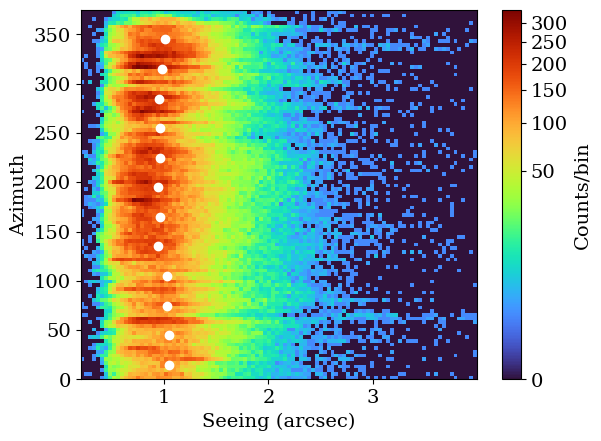

In [32]:
trimmed = fixed[np.isfinite(fixed['seeing']) & np.isfinite(fixed['az'])]
trim_az = trimmed['az'].astype(float)
trim_az[trim_az < 0] += 360.
az_seeing = trimmed['seeing'].astype(float)
azs = [15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345]
a_meds = []
for az in azs:
    seeing_slice = az_seeing[(trim_az >= az-15) & (trim_az <= az+15)]
    a_meds.append(np.median(seeing_slice))
with plt.style.context('default'):
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    plt.hist2d(az_seeing, trim_az, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Azimuth")
    cb = plt.colorbar()
    cb.set_label("Counts/bin")
    plt.scatter(a_meds, azs, color='w')
    plt.savefig("seeing_azimuth.png")
    plt.savefig("seeing_azimuth.png")
    plt.show()

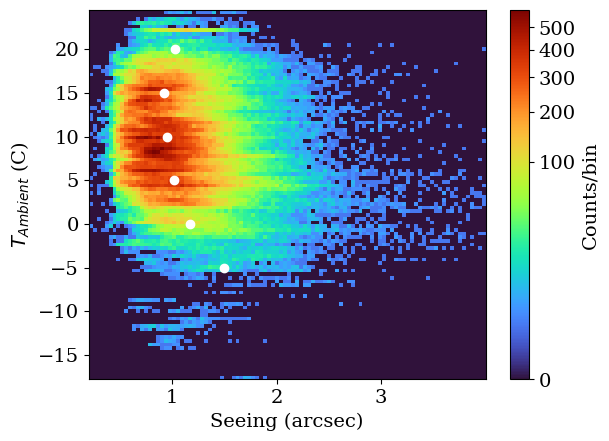

In [33]:
trimmed = fixed[np.isfinite(fixed['seeing']) & np.isfinite(fixed['outt'])]
trim_outt = trimmed['outt'].astype(float)
outt_seeing = trimmed['seeing'].astype(float)
temps = list(range(-5, 25, 5))
temps_meds = []
for t in temps:
    seeing_slice = outt_seeing[(trim_outt >= t-2.5) & (trim_outt <= t+2.5)]
    temps_meds.append(np.median(seeing_slice))
with plt.style.context('default'):
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    plt.hist2d(outt_seeing, trim_outt, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("$T_{Ambient}$ (C)")
    cb = plt.colorbar()
    cb.set_label("Counts/bin")
    plt.scatter(temps_meds, temps, color='w')
    plt.savefig("seeing_ambient.pdf")
    plt.savefig("seeing_ambient.png")
    plt.show()

In [215]:
temps

[-5, 0, 5, 10, 15, 20]